In [2]:
# Import dependency libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
import sympy
from tqdm import tqdm
import torch
import setuptools

In [3]:
# pip install git+https://github.com/KindXiaoming/pykan.git
# pip install xgboost

# Idea: Compare KAN to GBT/XGBoost and NN Methods on Iris Dataset
## How do KANs perform and compare on tabular data classification tasks? 

## 0.) Load Iris Data

In [4]:
from sklearn import datasets

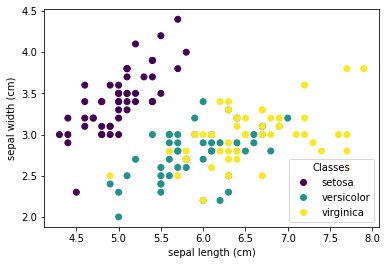

In [5]:
# Directly from sklearn documentation
iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [6]:
import pandas as pd

# Convert iris data to a pandas DataFrame
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['target'] = iris.target # convert to 0,1,2 category labels. 

## 1.) Build and train a simple NN

In [7]:
import torch.nn as nn

# Define the neural network
class FlowerNet(nn.Module):
    def __init__(self, input_size):
        super(FlowerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)  # Input layer (5 inputs) to hidden layer (10 nodes)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 3)  # Hidden layer to output layer (3 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Apply ReLU activation to the hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)              # Output layer (no activation)
        return x

In [8]:
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Note: Throughout notebook test size is 30% of data

Epoch 0, CE Loss: 1.0665, Training Accuracy: 35.24%, Test Accuracy: 28.89%
Epoch 50, CE Loss: 0.9851, Training Accuracy: 35.24%, Test Accuracy: 28.89%
Epoch 100, CE Loss: 0.9048, Training Accuracy: 35.24%, Test Accuracy: 28.89%
Epoch 150, CE Loss: 0.8192, Training Accuracy: 39.05%, Test Accuracy: 33.33%
Epoch 200, CE Loss: 0.7284, Training Accuracy: 73.33%, Test Accuracy: 77.78%
Epoch 250, CE Loss: 0.6328, Training Accuracy: 82.86%, Test Accuracy: 80.00%
Epoch 300, CE Loss: 0.5424, Training Accuracy: 89.52%, Test Accuracy: 86.67%
Epoch 350, CE Loss: 0.4672, Training Accuracy: 93.33%, Test Accuracy: 95.56%
Epoch 400, CE Loss: 0.4069, Training Accuracy: 94.29%, Test Accuracy: 97.78%
Epoch 450, CE Loss: 0.3570, Training Accuracy: 95.24%, Test Accuracy: 97.78%
Epoch 500, CE Loss: 0.3142, Training Accuracy: 96.19%, Test Accuracy: 100.00%
Epoch 550, CE Loss: 0.2771, Training Accuracy: 97.14%, Test Accuracy: 100.00%
Epoch 600, CE Loss: 0.2453, Training Accuracy: 97.14%, Test Accuracy: 100.00%

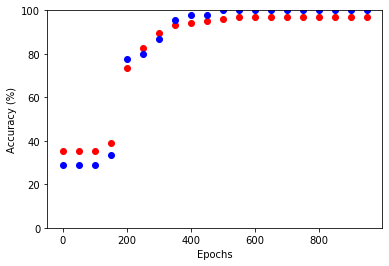

In [9]:
import torch.optim as optim

# Test Data
X__ = X_test.values
y__ = y_test.values

X__tensor = torch.from_numpy(X__).float()
y__tensor = torch.from_numpy(y__).long()

# Training Data
X_ = X_train.values
y_ = y_train.values

X_tensor = torch.from_numpy(X_).float()
y_tensor = torch.from_numpy(y_).long()

input_size = X_tensor.shape[1]

# Create an instance of the network
net = FlowerNet(input_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    # Forward pass
    outputs = net(X_tensor)

    # Compute the loss
    loss = criterion(outputs, y_tensor)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute accuracy - Train
    _, predicted = torch.max(outputs.data, 1)
    total = y_tensor.size(0)
    train_correct = (predicted == y_tensor).sum().item()
    train_accuracy = 100 * train_correct / total

    # Compute accuracy - Test
    test_outputs = net(X__tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    total = y__tensor.size(0)
    test_correct = (predicted == y__tensor).sum().item()
    test_accuracy = 100 * test_correct / total    

    # Print the loss every 10 epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, CE Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
        plt.scatter(epoch, train_accuracy, color = 'r', label = "Training Accuracy")
        plt.scatter(epoch, test_accuracy, color = 'b', label = "Test Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.ylim(0, 100)

## 2.) Build a Simple Gradient Boosted Tree Classifier

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

y = df['target']
X = df.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
# Note: Throughout notebook test size is 30% of data

In [11]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

GBT_test_acc = clf.score(X_test, y_test)
GBT_train_acc = clf.score(X_train, y_train)

print("Gradient Boosted Tree Classifier Train Accuracy (%): "+str( (100 * GBT_train_acc).round(2) ) )
print("Gradient Boosted Tree Classifier Test Accuracy (%): "+str( (100 * GBT_test_acc).round(2) ) )

Gradient Boosted Tree Classifier Train Accuracy (%): 100.0
Gradient Boosted Tree Classifier Test Accuracy (%): 95.56


## 2.5) Build XGBoost 2.0 Classifier

In [12]:
import xgboost as xgb

In [13]:
clf2 = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda").fit(X_train, y_train)

XGB_train_acc = clf2.score(X_train, y_train)
XGB_test_acc = clf2.score(X_test, y_test)

print("XGBoost Classifier Train Accuracy (%): "+str( (100 * XGB_train_acc).round(2) ) )
print("XGBoost Classifier Test Accuracy (%): "+str( (100 * XGB_test_acc).round(2) ) )

XGBoost Classifier Train Accuracy (%): 100.0
XGBoost Classifier Test Accuracy (%): 100.0


## 3.) Build and train a KAN on the data

In [14]:
from kan import KAN
from kan import * 
from kan import create_dataset

In [15]:
# Collect data into train_input, test_input, train_label, test_label tensors for KAN 

y = df['target']
X = df.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Note: Throughout notebook test size is 30% of data

# Test Data
X__ = X_test.values
y__ = y_test.values
X__tensor = torch.from_numpy(X__).float()
y__tensor = torch.from_numpy(y__).long()

# Training Data
X_ = X_train.values
y_ = y_train.values
X_tensor = torch.from_numpy(X_).float()
y_tensor = torch.from_numpy(y_).long()

# Create Dataset
dataset = {}
dataset['train_input'] = X_tensor 
dataset['test_input']  = X__tensor 
dataset['train_label'] = y_tensor
dataset['test_label']  = y__tensor

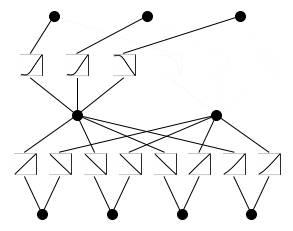

In [16]:
# Create KAN Model and visualize

model = KAN( width=[4, 2, 3], grid=5, k=3, seed=0, noise_scale_base = 0.5)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

model(dataset['train_input']);
beta = 10
model.plot(beta=beta)

train loss: 4.19e-04 | test loss: 4.38e-01 | reg: 4.48e+01 : 100%|██| 10/10 [00:02<00:00,  4.16it/s]


Training Accuracy (%): 100.0
Test Accuracy (%): 97.78


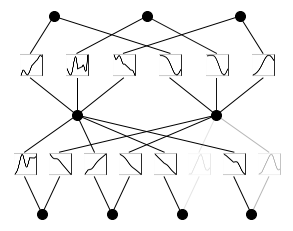

In [17]:
# Train KAN - Only 10 steps! 
model.train(dataset, opt="LBFGS", steps=10,  metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());
model.plot()
print("Training Accuracy (%): "+str( ( 100*train_acc().numpy()).round(2) ) )
print("Test Accuracy (%): "+str( ( 100*test_acc().numpy()).round(2) ) )

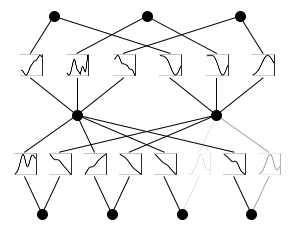

In [18]:
# Auto-prune model. No easy removals in this model. 
model = model.prune(threshold = 1e-2)
model(dataset['train_input'])
model.plot()

In [19]:
print("Pruned Training Accuracy (%): "+str( ( 100*train_acc().numpy()).round(2) ) )
print("Pruned Test Accuracy (%): "+str( ( 100*test_acc().numpy()).round(2) ) )

Pruned Training Accuracy (%): 100.0
Pruned Test Accuracy (%): 97.78


Many of the functions learned look reasonable at a glance, but there are a few nasty ones. Training a larger KAN would probably smooth them out, and may also create unneeded edges that can be pruned. 

## Experiment with analytic representation.
Pretty sure this is not in a good state for multiclass classification problems. Still, cool to check out.  

In [20]:
# Find symbolic expression f(x_1, x_2, x_3, x_4)

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
# lib = ['x','x^2','exp','log','sin'] # A reduced analytic library
model.auto_symbolic(lib=lib)
formula1 = model.symbolic_formula()[0][0]

print("An approximate decifision funciton: ")
formula1

fixing (0,0,0) with sin, r2=0.7819550633430481
fixing (0,0,1) with tanh, r2=0.9837462902069092
fixing (0,1,0) with tanh, r2=0.987891435623169
fixing (0,1,1) with tanh, r2=0.9958316683769226
fixing (0,2,0) with sqrt, r2=0.9985079169273376
fixing (0,2,1) with sin, r2=0.9779541492462158
fixing (0,3,0) with exp, r2=0.9873327016830444
fixing (0,3,1) with sin, r2=0.9781281352043152
fixing (1,0,0) with sin, r2=0.9673375487327576
fixing (1,0,1) with sin, r2=0.5467957854270935
fixing (1,0,2) with tanh, r2=0.9391576051712036
fixing (1,1,0) with sin, r2=0.9876739978790283
fixing (1,1,1) with sin, r2=0.9823501110076904
fixing (1,1,2) with sin, r2=0.9963653683662415
An approximate decifision funciton: 


-155.45*sin(-6.19*sqrt(1 - 0.08*x_3) + 0.27*exp(0.77*x_4) - 0.13*sin(3.59*x_1 + 0.48) + 0.58*tanh(3.6 - 1.04*x_2) + 10.91) - 34.39*sin(0.25*sin(1.23*x_3 - 9.75) + 0.31*sin(2.71*x_4 - 2.05) + 2.55*tanh(2.6 - 0.85*x_2) + 1.33*tanh(4.4 - 0.63*x_1) - 0.09) + 39.53

In [23]:
def acc(formula1, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2]).subs('x_4', X[i,3])).astype(np.float64)
        
        if int( logit1 + 0.5 ) == y[i]:
            correct = correct+1
            
    return correct/batch

print('Training accuracy of the formula:', acc(formula1, dataset['train_input'], dataset['train_label']),"(%) ")
# zero out of 105 

Training accuracy of the formula: 0.0 (%) 
